In [1]:
# Install snorkel into the environment. Must be rerun if environment is reset
!pip3 install snorkel

     |████████████████████████████████| 103 kB 5.2 MB/s 
     |████████████████████████████████| 5.6 MB 36.0 MB/s 
     |████████████████████████████████| 22.3 MB 2.5 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [44]:
# --- Imports ------------------------------------------------------------------
import numpy as np

from skimage.morphology import reconstruction
from skimage import filters

from scipy.signal import find_peaks
from scipy.fft import fft, fftn

from snorkel.labeling import labeling_function

# --- Noisy labeling Functions for MNIST dataset -------------------------------

# Continuous variable functions and their helper functions return continuous
# variables for classifying MNIST data, Snorkel labeling functions return class
# labels based on continuous variables and are prefixed classify.

# counts nonempty (greater than lowestValue) pixels in the image array x
def pixelCount(x, lowestValue=-1, axis=None):
    return np.count_nonzero(x > lowestValue, axis=axis)

@labeling_function()
def classifyPixelCount(x):
    # Return a label of 0 if pixelCount() < threshold, otherwise 1
    threshold = 135 # threshold between 0 and 1
    var = pixelCount(x)

    if var < threshold:
        return 1
    else:
        return 0

def fill(image): # fills enclosed areas in image and returns filled image
    seed = image.copy()
    seed[1:-1, 1:-1] = image.max()
    mask = image
    filledImage = reconstruction(seed, mask, method='erosion')
    return filledImage

# fills enclosed parts and returns count of nonempty pixels
def fillCount(x,lowestValue=-1): 
    image = x.reshape(28,28)
    filledImage = fill(image)
    count = pixelCount(filledImage,lowestValue=lowestValue)
    return count

@labeling_function()
def classifyFillCount(x):
    # Return a label of 0 if fillCount() < threshold, otherwise 1
    threshold = 160 # threshold between 0 and 1
    var = fillCount(x)

    if var < threshold:
        return 1
    else:
        return 0

def fillSum(x): # fills enclosed parts and sums grayscale image
    image = x.reshape(28, 28)
    filled = fill(image)
    return np.sum(filled)

@labeling_function()
def classifyFillSum(x):
    var = fillSum(x)

    if var < -550:
        return 1
    else: 
      return 0

def l2Norm(x): # returns the L2 norm of the image
    image = x.reshape(28, 28)
    ones=np.ones_like(image)*-1
    return np.linalg.norm(image-ones)

@labeling_function()
def classifyL2Norm(x):
    # Return a label of 0 if l2Norm() < threshold, otherwise 1
    threshold = 18 # threshold between 0 and 1
    var = l2Norm(x)

    if var < threshold:
        return 1
    else:
        return 0

# returns peak count in nonempty pixel count in one direction of the image
def peakCount(x, lowestValue, height, prominence, axis):
    counts = pixelCount(x, lowestValue, axis)
    numPeaks = len(find_peaks(counts, height=height, prominence=prominence)[0])
    return numPeaks

# returns peak count in the horizontal direction
def horizontalPeakCount(x, lowestValue=-1):
    height = 7
    prominence = None
    image = x.reshape(28,28)
    return peakCount(image, lowestValue, height, prominence, axis=0)

@labeling_function()
def classifyHorizontalPeakCount(x):
    var = horizontalPeakCount(x)

    if var < 1:
        return 1
    else:
        return 0

# returns peak count in the vertical direction
def verticalPeakCount(x, lowestValue=-1):
    height = None
    prominence = 8
    image = x.reshape(28,28)
    return peakCount(image, lowestValue, height, prominence, axis=1)

@labeling_function()
def classifyVerticalPeakCount(x):
    # Return a label of 0 if verticalPeakCount() < threshold, otherwise 1
    threshold = 1.5 # threshold between 0 and 1
    var = verticalPeakCount(x)

    if var < threshold:
        return 1
    else:
        return 0

# returns ratio of peaks in horizontal direction to peaks in vertical direction
def ratioPeakCount(x, lowestValue=-0.5):
    vpc = verticalPeakCount(x, lowestValue)
    if vpc == 0:
        return horizontalPeakCount(x, lowestValue)
    else:
        return horizontalPeakCount(x, lowestValue)/vpc

@labeling_function()
def classifyRatioPeakCount(x):
    var = ratioPeakCount(x)

    if var < 1:
        return 1
    else:
        return 0

# does roberts edge detection and counts peaks in the vertical direction
def edgeDetectVertical(x,lowestValue=0):
    image = x.reshape(28, 28)
    edgeImage = filters.roberts(image)
    return verticalPeakCount(edgeImage, lowestValue=lowestValue)

@labeling_function()
def classifyEdgeDetectVertical(x):
    # Return a label of 0 if edgeDetectVertical() < threshold, otherwise 1
    threshold = 1 # threshold between 0 and 1
    var = edgeDetectVertical(x)

    if var < threshold:
        return 1
    else:
        return 0

# does roberts edge detection and counts peaks in the horizontal direction
def edgeDetectHorizontal(x):
    image = x.reshape(28, 28)
    edgeImage = filters.roberts(image)
    return horizontalPeakCount(edgeImage, lowestValue=0)

@labeling_function()
def classifyEdgeDetectHorizontal(x):
    # Return a label of 0 if edgeDetectHorizontal() < threshold, otherwise 1
    threshold = 2 # threshold between 0 and 1
    var = edgeDetectHorizontal(x)

    if var < threshold:
        return 1
    else:
        return 0

# edge detection and returns ratio of peaks in horizontal and vertical direction
def edgeDetectRatio(x,lowestValue=0):
    image = x.reshape(28, 28)
    edgeImage = filters.roberts(image)
    return ratioPeakCount(edgeImage, lowestValue=lowestValue)

@labeling_function()
def classifyEdgeDetectRatio(x):
    # Return a label of 0 if edgeDetectRatio() < threshold, otherwise 1
    threshold = 2 # threshold between 0 and 1
    var = edgeDetectRatio(x)

    if var < threshold:
        return 1
    else:
        return 0

def fourierTransform1D(x):
    x = x.reshape(784)
    yf = fft(x)
    coefficients = 3
    # sum of the fourier coeficients
    return np.sum(2.0 /(28*28) * np.abs(yf[0:coefficients]))

@labeling_function()
def classifyFourierTransform1D(x):
    var = fourierTransform1D(x)

    if var < 1.8:
        return 0
    else:
        return 1

def fourierTransform2D(x):
    x = x.reshape(28,28)
    yf = fftn(x)
    # take first 10 coeficients
    return np.sum(np.abs(yf)[:10,:10])

@labeling_function()
def classifyFourierTransform2D(x):
    var = fourierTransform2D(x)

    if var < 2300:
        return 1
    else:
        return 0

In [15]:
# --- Imports ------------------------------------------------------------------
import numpy as np

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# --- Load MNIST Data ----------------------------------------------------------
def loadMNIST():
    batch_size = 12665

    # tensor and normalization transforms
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,)),
    ])

    # load MNIST data from dataset
    train_data = datasets.MNIST(
        root='input/data',
        train=True,
        download=True,
        transform=transform
    )

    # resample to binary dataset
    idx = (train_data.targets == 0) | (train_data.targets == 1)
    train_data.targets = train_data.targets[idx]
    train_data.data = train_data.data[idx]

    # DataLoader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    examples = enumerate(train_loader)
    batch_idx, (example_data, example_targets) = next(examples)

    # put targets and data in numpy arrays
    data = []
    for value in example_data:
        data.append(np.array(value[0]))

    targets = []
    for value in example_targets:
        targets.append(int(value))

    return data, targets


Pixel Sum 301.68172693344025
CBS 80.62439270700322
CGS -123.53375754387719
L2 Norm 13.425044931481068
HPC 1.6523366281620415
VPC 3.1145084744485096
RPC 5.553380586331641
EDV 1.619163824165812
EDH 2.5869410156673416
EDR 3.7040588625201716
FFT 1D 1.5714025946899135
FFT 2D 2077.044888451166


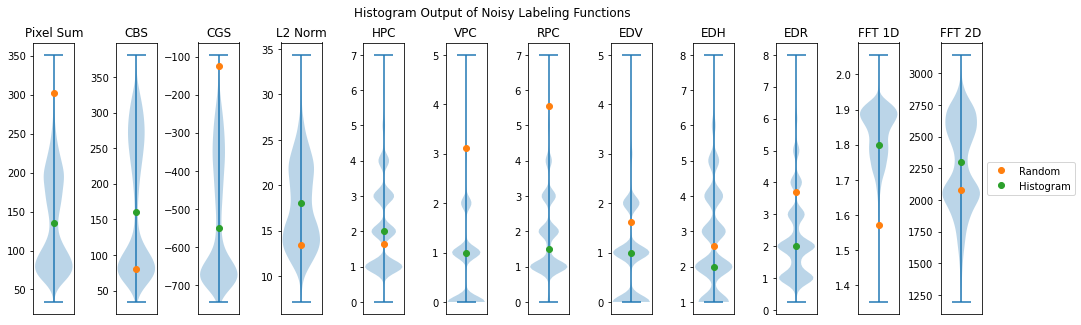

In [40]:
# --- Imports ------------------------------------------------------------------
import matplotlib.pyplot as plt

import random 

# Run through entire dataset and collect results from a noisy label function
def getFullResults():
    data, targets = loadMNIST()

    lfs = [
        pixelCount,
        fillCount,
        fillSum,
        l2Norm,
        horizontalPeakCount,
        verticalPeakCount,
        ratioPeakCount,
        edgeDetectVertical,
        edgeDetectHorizontal,
        edgeDetectRatio,
        fourierTransform1D,
        fourierTransform2D
    ]

    results = np.empty([len(lfs), 12665])

    for i, d in enumerate(data):
        for j, labFunc in enumerate(lfs):
            results[j][i] = labFunc(d)
    
    return results

# Visualize results of noisy labelling functions with violin plots
def plotHist(results):
    fig, ax = plt.subplots(1, 12)
    plt.suptitle("Histogram Output of Noisy Labeling Functions\n")

    names = ["Pixel Sum", "CBS", "CGS", "L2 Norm", "HPC", "VPC", "RPC", "EDV", "EDH", "EDR", "FFT 1D", "FFT 2D"]
    hist = [135, 160, -550, 18, 2, 1, 1.5, 1, 2, 2, 1.8, 2300]

    for i, r in enumerate(results):
        resultsMin = int(np.min(r))
        resultsMax = int(np.max(r))
        random.seed(i)
        randThresh = random.uniform(resultsMin, resultsMax)
        print(names[i], randThresh)

        # plt.figure()
        ax[i].set_title(names[i])
        ax[i].violinplot(r)
        ax[i].plot(1, randThresh, 'o')
        ax[i].plot(1, hist[i], 'o')
        ax[i].axes.get_xaxis().set_visible(False)

    plt.legend(["Random", "Histogram"], loc='center left', bbox_to_anchor=(1, 0.5))
    fig.set_size_inches(17, 5)
    plt.subplots_adjust(wspace=1)
    plt.savefig("hists.png", dpi=200)

if __name__ == "__main__":
    results = getFullResults()
    plotHist(results)


In [45]:
# --- Imports ------------------------------------------------------------------
from snorkel.labeling import LFAnalysis
from snorkel.labeling import LFApplier
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import labeling_function

# --- Snorkel Labeling Model ---------------------------------------------------
def getLabelMatrix(lfs):
    # create L from data; matrix of labeling functions and their classifications
    applier = LFApplier(lfs=lfs)
    labelMatrix = applier.apply(data)
    return labelMatrix

def getMajorityPredictions(labelMatrix):
    # majority model
    majority_model = MajorityLabelVoter()
    majorityPreds = majority_model.predict(L=labelMatrix)
    return majorityPreds

def getModelPredictions(labelMatrix):
    # Snorkel labeling model
    label_model = LabelModel(cardinality=2, verbose=True)
    label_model.fit(L_train=labelMatrix, n_epochs=500, log_freq=100, seed=123)
    modelPreds = label_model.predict(L=labelMatrix)
    return modelPreds

def printModelAccuracy(predictions, targets, modelName):
    correct = 0
    for p, t in zip(predictions, targets):
        if p == t:
            correct += 1

    percent = (correct/len(targets))*100
    print("Correctly classified by the ", modelName, ": ", percent)

def printLFAccuracy(labelMatrix, lfs, targets):
    correct = np.zeros_like(lfs)
    total = np.zeros_like(lfs)

    for lm, t in zip(labelMatrix, targets):
        for i in range(0, len(lfs)):
            if lm[i] == t:
                correct[i] += 1
            if lm[i] != -1:
                total[i] += 1

    percentCorrect = []
    for c, t in zip(correct, total):
        percent = (c/t)*100
        percentCorrect.append(percent)
    
    print(lfs)
    print(percentCorrect)

if __name__ == "__main__":
    # labeling functions list

    # After Visualization labeling Function Set
    # lfs = [
    #     classifyFillSum,
    #     classifyFourierTransform1D,
    #     classifyFourierTransform2D,
    #     classifyHorizontalPeakCount,
    #     classifyRatioPeakCount,
    # ]

    lfs = [
           classifyPixelCount,
           classifyFillCount,
           classifyFillSum,
           classifyL2Norm,
           classifyHorizontalPeakCount,
           classifyVerticalPeakCount,
           classifyRatioPeakCount,
           classifyEdgeDetectHorizontal,
           classifyEdgeDetectRatio,
           classifyEdgeDetectVertical,
           classifyFourierTransform1D,
           classifyFourierTransform2D
    ]

    data, targets = loadMNIST()
    labelMatrix = getLabelMatrix(lfs)
    printLFAccuracy(labelMatrix, lfs, targets)
    print(LFAnalysis(L=labelMatrix, lfs=lfs).lf_summary())
    majorityPreds = getMajorityPredictions(labelMatrix)
    modelPreds = getModelPredictions(labelMatrix)
    printModelAccuracy(majorityPreds, targets, "Majority Model")
    printModelAccuracy(modelPreds, targets, "Label Model")


12665it [00:33, 383.73it/s]


[LabelingFunction classifyPixelCount, Preprocessors: [], LabelingFunction classifyFillCount, Preprocessors: [], LabelingFunction classifyFillSum, Preprocessors: [], LabelingFunction classifyL2Norm, Preprocessors: [], LabelingFunction classifyHorizontalPeakCount, Preprocessors: [], LabelingFunction classifyVerticalPeakCount, Preprocessors: [], LabelingFunction classifyRatioPeakCount, Preprocessors: [], LabelingFunction classifyEdgeDetectHorizontal, Preprocessors: [], LabelingFunction classifyEdgeDetectRatio, Preprocessors: [], LabelingFunction classifyEdgeDetectVertical, Preprocessors: [], LabelingFunction classifyFourierTransform1D, Preprocessors: [], LabelingFunction classifyFourierTransform2D, Preprocessors: []]
[97.00750098697198, 98.76825898144492, 96.7785234899329, 91.54362416107382, 47.09830240821161, 65.8744571654165, 49.040663245163834, 70.74615080931702, 65.5507303592578, 86.85353335965259, 84.06632451638374, 96.0757994472957]
                               j Polarity  Coverag

INFO:root:Computing O...
INFO:root:Estimating \mu...
 60%|██████    | 300/500 [00:00<00:00, 1027.96epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.117]
INFO:root:[400 epochs]: TRAIN:[loss=0.117]
100%|██████████| 500/500 [00:00<00:00, 1029.63epoch/s]
INFO:root:Finished Training


Correctly classified by the  Majority Model :  96.29688116857481
Correctly classified by the  Label Model :  97.08645874457166
